# Transfer Learning Part 2: Fine-tuning

## IMporting helper functions

Rewriting certain functions to monitor and evaluate our model can be tedious, so we can make our own script for some mundane activities

In [1]:
### Downloading hellper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-14 13:05:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-14 13:05:37 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# IMporting from helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get Some data

In [3]:
# Get 10% of our data and unzip it

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-14 13:05:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.5MB/s    in 8.3s    

2024-02-14 13:05:54 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory paths
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an axample of batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[254.       254.       254.      ]
   [254.       254.       254.      ]
   [254.       254.       254.      ]
   ...
   [252.       254.       253.      ]
   [252.       254.       253.      ]
   [252.       254.       253.      ]]

  [[254.       254.       254.      ]
   [254.       254.       254.      ]
   [254.       254.       254.      ]
   ...
   [252.92857  254.92857  253.92857 ]
   [252.92857  254.92857  253.92857 ]
   [252.92857  254.92857  253.92857 ]]

  [[254.       254.       254.      ]
   [254.       254.       254.      ]
   [254.       254.       254.      ]
   ...
   [253.       255.       254.      ]
   [253.       255.       254.      ]
   [253.       255.       254.      ]]

  ...

  [[254.       254.       254.      ]
   [254.       254.       254.      ]
   [254.       254.       254.      ]
   ...
   [254.       254.       254.      ]
   [254.       254.       254.      ]
   [254.       254.       254.      ]]

  [[254.       254.       254.    

## Model 0: Building a transfer learning model using Keras Functionsal API

The sequential API is straight-forwar, it runs our layers in sequential order.

But the functiosn API gives us more flexibility with our models

In [12]:
# 1. Create base model, with tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into out model
inputs = tf.keras.layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")

# 4. If using a model like ResNEt50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average poo the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)


# 8. Combing the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

# 10. Fit the model and save its hsitory
history_0 = model_0.fit(train_data,
                        epochs= 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= len(test_data),
                        callbacks= [create_tensorboard_callback(
                            dir_name= "tensorflow_hub", experiment_name= 'model_0')])

24274472/24274472 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/model_0/20240214-130606
Epoch 1/5
24/24 [==============================] - 27s 621ms/step - loss: 1.9380 - accuracy: 0.3827 - val_loss: 1.3841 - val_accuracy: 0.7064
Epoch 2/5
24/24 [==============================] - 7s 282ms/step - loss: 1.1682 - accuracy: 0.7547 - val_loss: 0.9290 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 7s 262ms/step - loss: 0.8603 - accuracy: 0.8187 - val_loss: 0.7401 - val_accuracy: 0.8304
Epoch 4/5
24/24 [==============================] - 7s 275ms/step - loss: 0.7097 - accuracy: 0.8360 - val_loss: 0.6405 - val_accuracy: 0.8464
Epoch 5/5
24/24 [==============================] - 7s 303ms/step - loss: 0.6051 - accuracy: 0.8600 - val_loss: 0.5822 - val_accuracy: 0.8576


In [13]:
# Evaluate
model_0.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.5822 - accuracy: 0.8576


[0.582194983959198, 0.8575999736785889]

In [14]:
# Check the layers in our base model
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [15]:
# how about we get the summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [16]:
# how about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

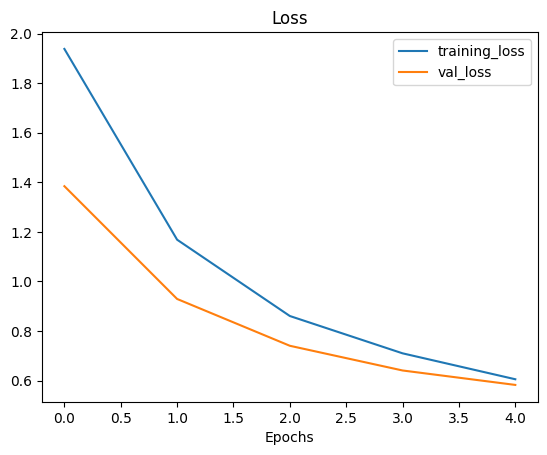

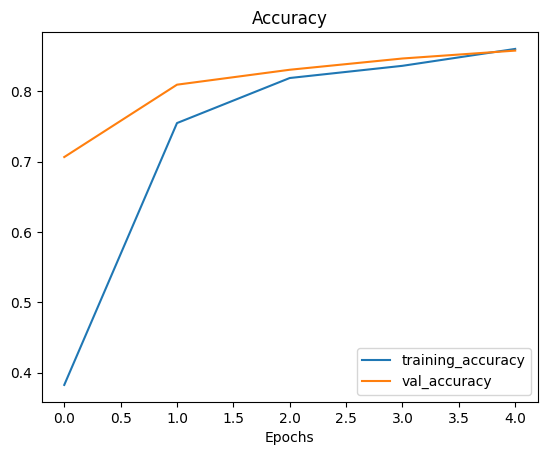

In [17]:
plot_loss_curves(history_0)

## Getting feature vector form trained model

Let's demonstrate GlobalAveragePooling2D layer

We have a tensor after our modle goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D.

In [18]:
# Define input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor: \n {input_tensor} \n")

# Passing the random tensor trhough a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

#Check the shape of the different tensord
print(f"Shape of input tensord: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensord: {global_average_pooled_tensor.shape}")

Random input tesnor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensord: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensord: (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis= [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> **Practice**: Try to do the same withthe above two cells but this time use `GlobalMaxPool2D` ... and see what happens

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunmch of experiments to find out:

1. `model_1` use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation


> **Note**: throughout all the experiments the same test dataset will be used to evaluate our model... thsi ensures consistency across evaluation metrics

## Getting and preprocessing our data for model_1

In [20]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-02-14 13:07:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.6MB/s    in 7.2s    

2024-02-14 13:07:23 (17.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [22]:
# Creating training and test dir
TRAIN_DIR_1 = "10_food_classes_1_percent/train/"
TEST_DIR_1 = "10_food_classes_1_percent/test/"

In [23]:
# Setup data loaders

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

test_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into out model, we can us the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this in the documentations of data augmentatioon inside the model

* Preprocessing of the images happens in GPU
* The preprocessing layers are also saved when the model is being saved to use as an idependent application

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) # Keep for models like ResNet50 but EfficientNet already has the layer in built
], name= "data_augmentation")

(-0.5, 511.5, 511.5, -0.5)

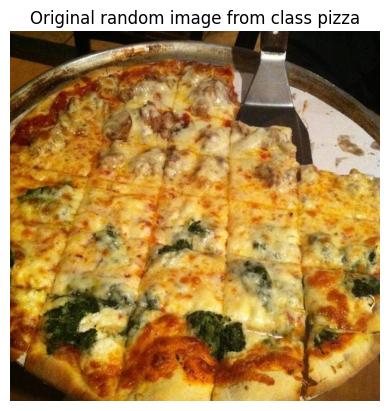

In [26]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

### Visualise or data augmentation layer

(-0.5, 446.5, 541.5, -0.5)

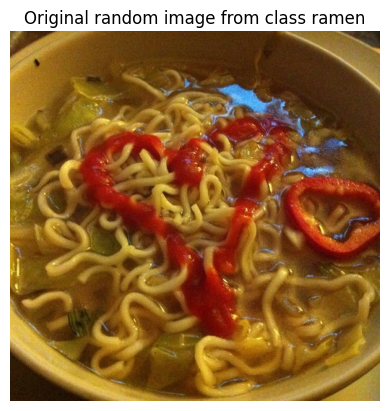

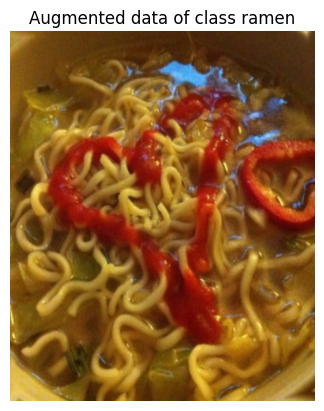

In [27]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis= 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented data of class {target_class}")
plt.axis(False)

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup the input shape and base model, freezing the base model layers

input_shape = IMG_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

base_model.trainable = False

# Create input layer
inputs = layers.Input(shape= input_shape, name= 'input_layer')

#Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training= False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

16705208/16705208 [==============================] - 2s 0us/step


In [29]:
history_1_percent = model_1.fit(train_data_1,
            epochs= 5,
            steps_per_epoch= len(train_data_1),
            validation_data= test_data_1,
            validation_steps= len(test_data_1),
            callbacks= [create_tensorboard_callback("tensorflow_hub", "1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20240214-130736
Epoch 1/5
3/3 [==============================] - 22s 5s/step - loss: 2.3208 - accuracy: 0.1429 - val_loss: 2.1179 - val_accuracy: 0.2632
Epoch 2/5
3/3 [==============================] - 8s 3s/step - loss: 1.9846 - accuracy: 0.3286 - val_loss: 1.9942 - val_accuracy: 0.3516
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.8529 - accuracy: 0.5000 - val_loss: 1.8831 - val_accuracy: 0.4080
Epoch 4/5
3/3 [==============================] - 9s 4s/step - loss: 1.6175 - accuracy: 0.6143 - val_loss: 1.7826 - val_accuracy: 0.4656
Epoch 5/5
3/3 [==============================] - 7s 4s/step - loss: 1.4794 - accuracy: 0.6429 - val_loss: 1.6919 - val_accuracy: 0.5020


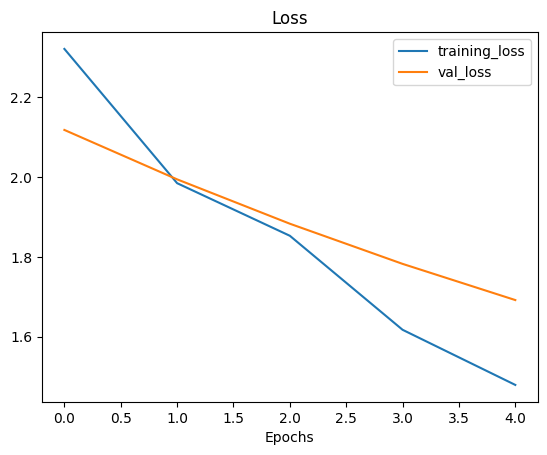

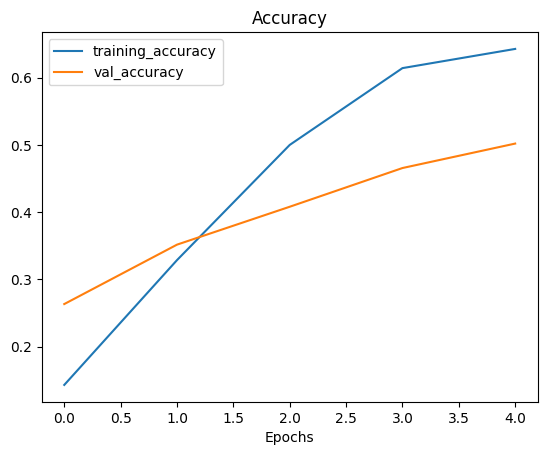

In [30]:
plot_loss_curves(history_1_percent)

In [31]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [32]:
# Evaluate
model_1.evaluate(test_data_1)

79/79 [==============================] - 6s 65ms/step - loss: 1.6919 - accuracy: 0.5020


[1.6919310092926025, 0.5019999742507935]

## Model 2: feature extraction transfer learning model with 10% data and data augmentation

In [33]:
# Get 10 % of our data
train_dir_10 = "10_food_classes_10_percent/train"
test_dir_10 = "10_food_classes_10_percent/test"

In [34]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [35]:
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [36]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRot  (None, None, None, 3)     0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeigh  (None, None, None, 3)     0         
 t)                                                              
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

In [37]:
# Create model 2 with data augmentation built in
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
], name= 'data_augmentation')

# Setup the input shape
input_shape = IMG_SIZE + (3, )

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape= input_shape, name= 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_poolonmg_2D')(x)
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [38]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_poolonmg_2D  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback immediately saves our model so that we can start where left.

In [39]:
# Set checkpoint path
checkpoint_path = 'model_checkpoints/weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, save_weights_only= True, save_best_only= False, save_freq= 'epoch', verbose= 1)

In [40]:
history_10_percent = model_2.fit(train_data_10,
            epochs= 5,
            steps_per_epoch= len(train_data_10),
            validation_data= test_data_10,
            validation_steps= len(test_data_10),
            callbacks= [create_tensorboard_callback('tensorflow_hub', "10_percent_data_aug"),
                        checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20240214-130856
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0133 - accuracy: 0.3413
Epoch 1: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 34s 1s/step - loss: 2.0133 - accuracy: 0.3413 - val_loss: 1.4484 - val_accuracy: 0.6752
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3097 - accuracy: 0.7080
Epoch 2: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 23s 956ms/step - loss: 1.3097 - accuracy: 0.7080 - val_loss: 0.9841 - val_accuracy: 0.7844
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9969 - accuracy: 0.7693
Epoch 3: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 21s 856ms/step - loss: 0.9969 - accuracy: 0.7693 - val_loss: 0.7950 - val_accuracy: 0.8136
Epoch 4/5
24/24 [==========================

In [41]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 61ms/step - loss: 0.5822 - accuracy: 0.8576


[0.5821949243545532, 0.8575999736785889]

In [42]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 6s 65ms/step - loss: 0.6257 - accuracy: 0.8404


[0.6256824731826782, 0.840399980545044]

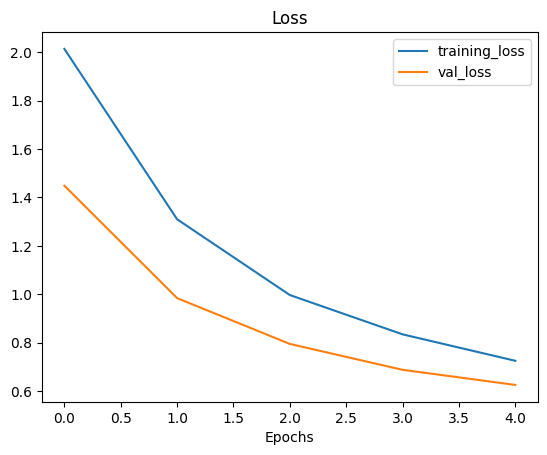

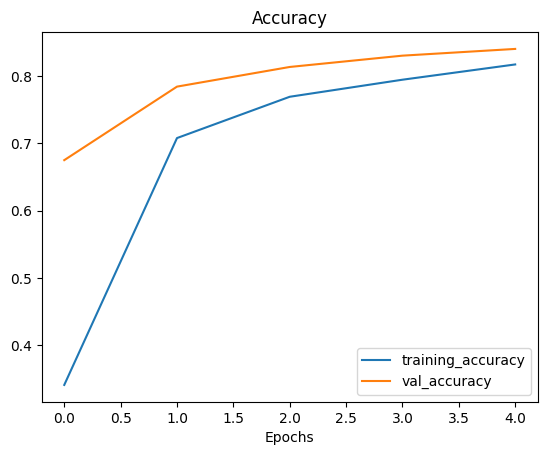

In [43]:
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights

Loading in checkpoint weights returns a model to a specific checkpoint

In [44]:
# Load in saved models weights and evaluate model
model_2.load_weights(checkpoint_path)

In [45]:
# Evaluate model_2 with loaded weights
model_2.evaluate(test_data_10)

79/79 [==============================] - 6s 65ms/step - loss: 0.6257 - accuracy: 0.8404


[0.6256824135780334, 0.840399980545044]

In [46]:
# Check to see if loaded model results are very close to our previous non-loaded model results

# import numpy as np
# np.isclose()

## Model 3: Fine-tuning an existing model on 10% of the data

> **Note**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of custom dataset

In [47]:
# Layers in loaded model
model_2.layers

In [48]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7c9e1eded810> True
<keras.src.engine.sequential.Sequential object at 0x7c9e1c7aa050> True
<keras.src.engine.functional.Functional object at 0x7c9e1c5d61d0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7c9e1c78fdc0> True
<keras.src.layers.core.dense.Dense object at 0x7c9e1eb35cc0> True


In [49]:
# LAyers in out base model and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [50]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [51]:
# To begin fine tuning let;s start by setting the last 10 layers of our bas_model.tranable = True

base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we recompile our models every time we make a change)
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001), # when fine tuning you typically want to lower your learning rate by 10x
                metrics= ['accuracy'])

> **Note**: When using fine-tuning, it is a best practice to lower your learning rate. A good thumb rule is to lower it by 10x

A good resource for information on this is the [ULMFit paper](https://arxiv.org/abs/1801.06146)

In [52]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [53]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are available
len(model_2.trainable_variables)

12

In [54]:
# Fine tune for another 5 epochs
fine_tune_epochs = 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent = model_2.fit(train_data_10,
                                      epochs= fine_tune_epochs,
                                      steps_per_epoch= len(train_data_10),
                                      validation_data= test_data_10,
                                      validation_steps= int(0.25 * len(test_data_10)),
                                      initial_epoch= history_10_percent.epoch[-1], # start training from prevous last epoch,
                                      callbacks= [create_tensorboard_callback('tensorflow_hub', '10_percent_fine_tune')])

Saving TensorBoard log files to: tensorflow_hub/10_percent_fine_tune/20240214-131145
Epoch 5/10
24/24 [==============================] - 27s 746ms/step - loss: 0.6109 - accuracy: 0.8360 - val_loss: 0.4956 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 16s 620ms/step - loss: 0.5188 - accuracy: 0.8560 - val_loss: 0.4569 - val_accuracy: 0.8503
Epoch 7/10
24/24 [==============================] - 14s 574ms/step - loss: 0.4419 - accuracy: 0.8813 - val_loss: 0.4362 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 14s 569ms/step - loss: 0.3925 - accuracy: 0.8933 - val_loss: 0.4244 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 14s 548ms/step - loss: 0.3472 - accuracy: 0.9000 - val_loss: 0.4271 - val_accuracy: 0.8618
Epoch 10/10
24/24 [==============================] - 13s 517ms/step - loss: 0.3446 - accuracy: 0.9000 - val_loss: 0.4316 - val_accuracy: 0.8586


In [55]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 6s 76ms/step - loss: 0.4268 - accuracy: 0.8572


[0.4268162250518799, 0.857200026512146]

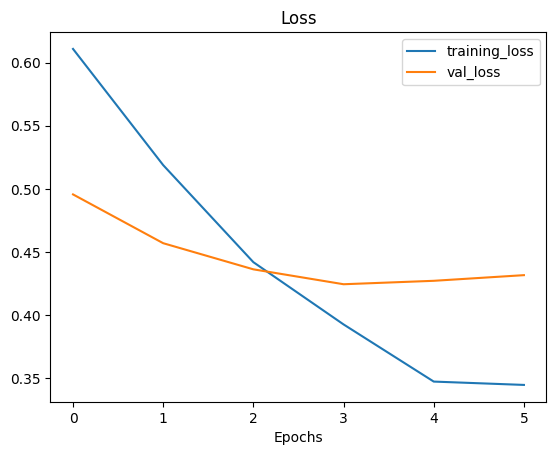

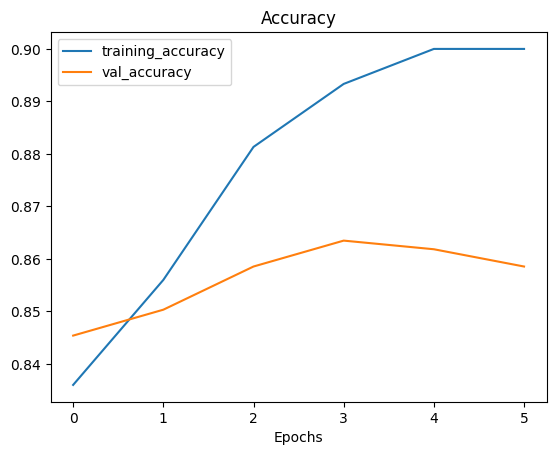

In [56]:
# Check out the loss curve of our fine tuned model
plot_loss_curves(history_fine_10_percent)

The `plot_loss_curve function` works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another

In [57]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs= 5):
    '''
    Comapres two Tensorflow History objects
    '''

    # Get original history measurements
    accuracy = original_history.history['accuracy']
    val_accuracy = original_history.history['val_accuracy']

    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']

    # Combine original history
    total_accuracy = accuracy + new_history.history['accuracy']
    total_val_accuracy = val_accuracy + new_history.history['val_accuracy']
    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plots
    plt.figure(figsize= (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_accuracy, label= 'Total Training Accuracy')
    plt.plot(total_val_accuracy, label= 'Total Testing Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label= 'Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label= 'Total Training Loss Values')
    plt.plot(total_val_loss, label= 'Total Testing Loss Values')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label= 'Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Loss Value")

    plt.tight_layout()

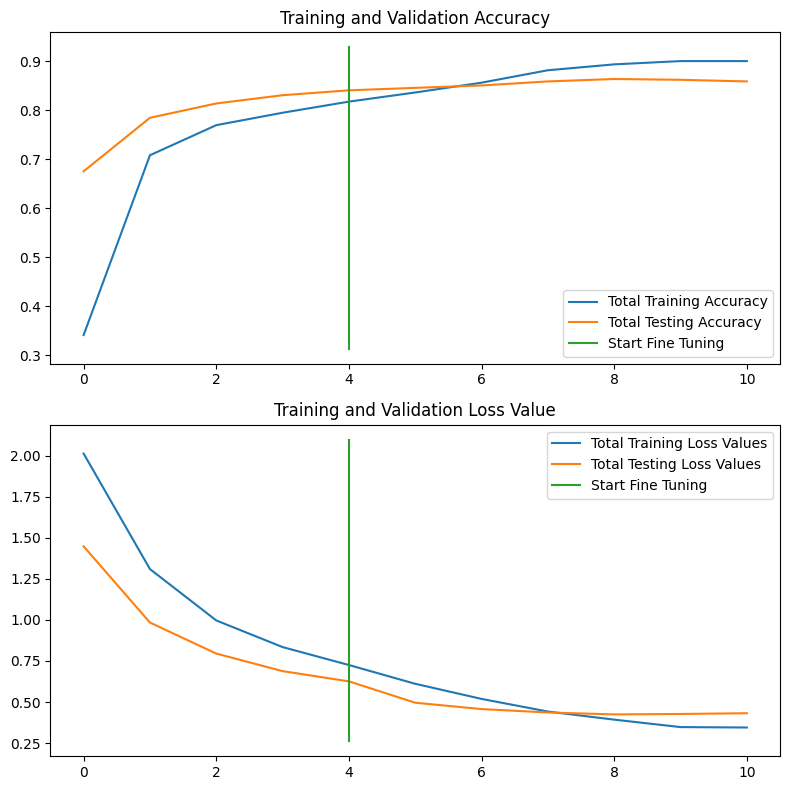

In [58]:
compare_histories(original_history= history_10_percent,
                  new_history= history_fine_10_percent,
                  initial_epochs= 5)

## Model 4: Fine-tuning and existing model on all the data

In [59]:
# Download and unzip 10 classes of Fodd101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2024-02-14 13:13:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.0MB/s    in 22s     

2024-02-14 13:14:10 (22.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [60]:
# Setup training and test dir
TRAIN_DIR_2 = "10_food_classes_all_data/train"
TEST_DIR_2 = "10_food_classes_all_data/test"

In [61]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [62]:
# Setup data inputs
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR_2, label_mode= LABEL_MODE, image_size= IMG_SIZE, batch_size= BATCH_SIZE)

test_data_full = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR_2, label_mode= LABEL_MODE, image_size= IMG_SIZE, batch_size= BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in it is the same as what we've been using for previous experiments

Let's verify

In [63]:
# Evaluate model_2
model_2.evaluate(test_data_full)

79/79 [==============================] - 6s 64ms/step - loss: 0.4268 - accuracy: 0.8572


[0.42681625485420227, 0.857200026512146]

To train a fine-tuning model we need to revert model_2 back to its feature extraction weights

In [64]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [65]:
model_2.evaluate(test_data_full)

79/79 [==============================] - 7s 75ms/step - loss: 0.6257 - accuracy: 0.8404


[0.6256825923919678, 0.840399980545044]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% percent of the data with data augmnetation and we saved model's weight using `ModelCheckpoint` Callback
2. Fine-tuned to same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unforzen
3. Saved the results and training logs each time
4. Reloaded the model from step 1 to do the same steps as stpe 2 except this time we're going to use all of the data

In [66]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_poolonmg_2D True
4 output_layer True


In [67]:
# Let's drill into our base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [68]:
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001),
                metrics= ['accuracy'])

In [69]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [70]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = 7

history_fine_full = model_2.fit(train_data_full,
                                epochs= fine_tune_epochs,
                                validation_data= test_data_full,
                                validation_steps= int(0.25 * len(test_data_full)),
                                initial_epoch= 4,
                                callbacks= [create_tensorboard_callback('tensorflow_hub', 'full_10_classes_fine_tune')])

Saving TensorBoard log files to: tensorflow_hub/full_10_classes_fine_tune/20240214-131435
Epoch 5/7
235/235 [==============================] - 112s 440ms/step - loss: 0.6426 - accuracy: 0.7945 - val_loss: 0.3576 - val_accuracy: 0.8783
Epoch 6/7
235/235 [==============================] - 84s 354ms/step - loss: 0.5289 - accuracy: 0.8284 - val_loss: 0.2975 - val_accuracy: 0.9046
Epoch 7/7
235/235 [==============================] - 72s 302ms/step - loss: 0.4705 - accuracy: 0.8469 - val_loss: 0.3014 - val_accuracy: 0.9046


In [71]:
# Evaluate on all the test data
model_2.evaluate(test_data_full)

79/79 [==============================] - 7s 78ms/step - loss: 0.3093 - accuracy: 0.9000


[0.3093041479587555, 0.8999999761581421]

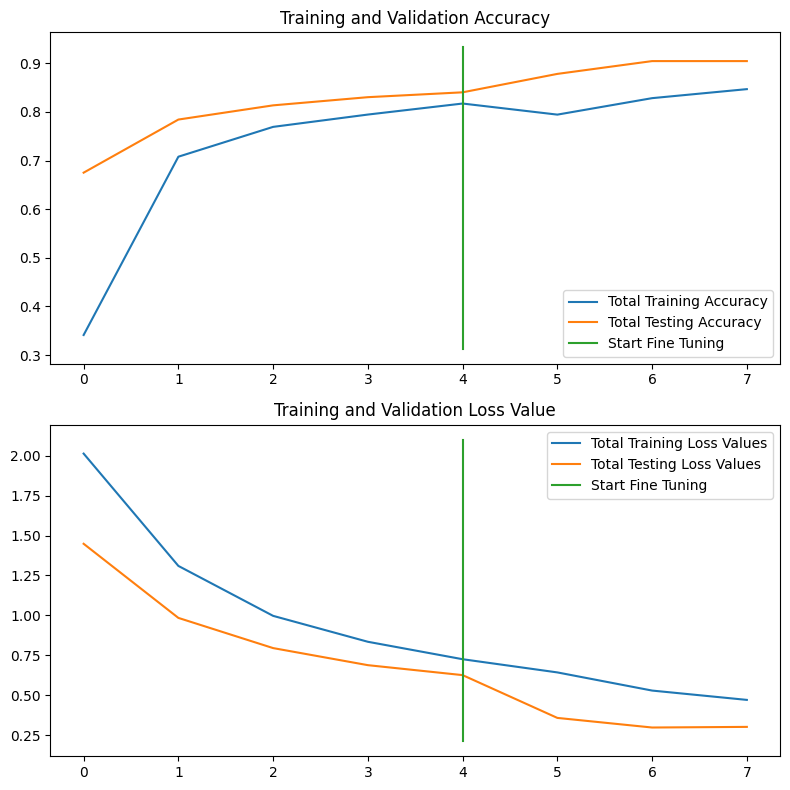

In [72]:
compare_histories(original_history= history_10_percent,
                  new_history= history_fine_full,
                  initial_epochs= 5)

## Viewing our experiment data on Tensorboard

In [73]:
!tensorboard dev upload --logdir ./tensorflow_hub \
--name "Transfer Learning Experiments with Food101 Classes" \
--description "A sereiec of different transfer learning experiments" \
--one_shot

2024-02-14 13:24:28.820808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 13:24:28.820882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 13:24:28.822181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 13:24:29.845635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb